In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import numpy as np
import string
from collections import defaultdict
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
import joblib
import pickle as pkl
import pandas as pd


Bad key "text.kerning_factor" on line 4 in
C:\Users\DELL\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# 1. Exploratory Data Analysis and Visualization

In [2]:
def open_file(filename):
    with open(filename, 'r', encoding = 'utf8') as f:
        data = f.readlines()
    return data

In [3]:
data_raw = dict()
data_raw['sk'] = open_file('train_sentences.sk')
data_raw['cs'] = open_file('train_sentences.cs')
data_raw['en'] = open_file('train_sentences.en')

In [4]:
def show_statistics(data):
    for language, sentences in data.items():
        num_sentences = len(sentences)
        word_list = ' '.join(sentences).split()
        num_words = len(word_list)
        num_unique_words = len(set(word_list))
        sample = sentences[0]
        
        print(f'Language : {language}')
        print(f'Number of sentences : {num_sentences}')
        print(f'Number of words : {num_words}')
        print(f'Number of unique words : {num_unique_words}')
        print(f'Sample Extract : {sample}')
        print()
        

In [5]:
show_statistics(data_raw)

Language : sk
Number of sentences : 100
Number of words : 2016
Number of unique words : 1322
Sample Extract : Pán de Grandes Pascual jasne vysvetlil, aká je pridaná hodnota definície terorizmu, vyjadrením, že definícia, ktorú sme používali predtým, bola dôležitejšia, ale aj tým, že trval na zozname priestupkov.


Language : cs
Number of sentences : 10
Number of words : 158
Number of unique words : 141
Sample Extract : Upozorňujeme, že jejím cílem je šetřit penězi za administrativní výdaje.


Language : en
Number of sentences : 100
Number of words : 2381
Number of unique words : 1037
Sample Extract : I can understand your approach a little bit.




In [6]:
def do_law_of_zipf(data):
    '''
    Convert a dictionary (keys are language, and values are lists of sentences)
    into separate Pandas DataFrames for each language, and plots log scales of
    Ranks vs Frequencies, to visualize Zipf's Law.
    
    '''
    languages = list(data.keys())
    
    words_df_dict = dict()
    
    for language in languages:
        words_df_dict[language] = pd.DataFrame()

        words = []
        for sentence in data[language]:
            words.extend(sentence.split())

        words_df_dict[language]['word'] = words
    '''
    The value_counts() function is used to get a Series containing counts of unique values. 
    The resulting object will be in descending order so that the first element is the most 
    frequently-occurring element.
    '''
    for language in languages:
        freqs = words_df_dict[language]['word'].value_counts().values
        ranks = range(1, len(freqs)+1)
        plt.plot(freqs, ranks, label=language)

    plt.ylabel('Frequency')
    plt.xlabel('Rank')
    plt.yscale('log')
    plt.xscale('log')

    plt.title('Zipf\'s Law')
    plt.legend()

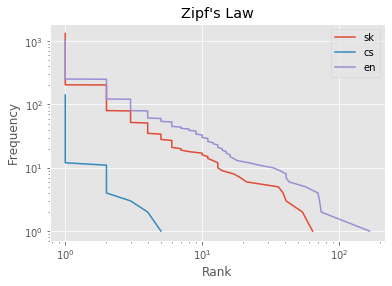

In [7]:
do_law_of_zipf(data_raw)

# 2. Data Cleaning and Preprocessing

In [8]:
def preprocess(text):
    '''
    Removes punctuation and digits from a string, and converts all characters to lowercase.
    Also clears all \n and hyphens
    
    Syntax : maketrans(str1, str2, str3)
    Parameters :
    str1 : Specifies the list of characters that need to be replaced.
    str2 : Specifies the list of characters with which the characters need to be replaced.
    str3 : Specifies the list of characters that needs to be deleted.
    Returns : Returns the translation table which specifies the conversions that can be used by translate()
    
    Syntax : translate(table, delstr)
    Parameters :
    table : Translate mapping specified to perform translations.
    delstr : The delete string can be specified as optional argument is not mentioned in table.
    Returns : Returns the argument string after performing the translations using the translation table.
    '''
    preprocessed_text = text.lower().replace('-', ' ')
    translation_table = str.maketrans('\n', ' ', string.punctuation+string.digits)
    preprocessed_text = preprocessed_text.translate(translation_table)
    
    return preprocessed_text

In [9]:
data_preprocessed = {k: [preprocess(sentence) for sentence in v] for k, v in data_raw.items()}

In [10]:
data_preprocessed['cs']

['upozorňujeme že jejím cílem je šetřit penězi za administrativní výdaje ',
 'zcela otevřeně přiznám že ne vždy rozumím extrémně složitým vědeckým analýzám které dostávám ',
 'při práci na této zprávě bylo třeba abych pracovala právě s touto představivostí ',
 'a nakonec plně podporuji myšlenku sjednotit vědeckovýzkumný sektor v energetické oblasti jakožto klíčový prvek dané dlouhodobé politiky ',
 'to je vážná věc ',
 'z tohoto hlediska zcela souhlasím s připomínkami pana verheugena ',
 'rozprava je ukončena ',
 'vzhledem k významu které má stavebnictví pro evropské hospodářství je nutné odstranit technické překážky bránící obchodu se stavebními výrobky v zájmu zlepšení jejich volného pohybu na vnitřním trhu ',
 'v roce  je to popáté kdy byly z tohoto fondu uvolněny prostředky přičemž byla využita celková částka  milionů eur z plánované výše  milionů eur ',
 've svém vystoupení bych chtěla ocenit návrhy paní zpravodajky anny záborské které doporučují uznat vedle tradiční oficiální výd

In [11]:
show_statistics(data_preprocessed)

Language : sk
Number of sentences : 100
Number of words : 1996
Number of unique words : 1207
Sample Extract : pán de grandes pascual jasne vysvetlil aká je pridaná hodnota definície terorizmu vyjadrením že definícia ktorú sme používali predtým bola dôležitejšia ale aj tým že trval na zozname priestupkov 

Language : cs
Number of sentences : 10
Number of words : 155
Number of unique words : 133
Sample Extract : upozorňujeme že jejím cílem je šetřit penězi za administrativní výdaje 

Language : en
Number of sentences : 100
Number of words : 2366
Number of unique words : 904
Sample Extract : i can understand your approach a little bit 



# 3. Base Naive Bayes Model

In [12]:
sentences_train, y_train = [], []

for k, v in data_preprocessed.items():
    for sentence in v:
        sentences_train.append(sentence)
        y_train.append(k)

In [13]:
vectorizer = CountVectorizer()

In [14]:
X_train = vectorizer.fit_transform(sentences_train)

In [15]:
X_train

<210x2208 sparse matrix of type '<class 'numpy.int64'>'
	with 3867 stored elements in Compressed Sparse Row format>

In [16]:
naive_classifier1 = MultinomialNB()
naive_classifier1.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [17]:
data_val = dict()
data_val['sk'] = open_file('val_sentences.sk')
data_val['cs'] = open_file('val_sentences.cs')
data_val['en'] = open_file('val_sentences.en')

In [18]:
data_val_preprocessed = {k: [preprocess(sentence) for sentence in v] for k, v in data_val.items()}

In [19]:
sentences_val, y_val = [], []

for k, v in data_val_preprocessed.items():
    for sentence in v:
        sentences_val.append(sentence)
        y_val.append(k)

In [20]:
X_val = vectorizer.transform(sentences_val)
predictions1 = naive_classifier1.predict(X_val)

In [21]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
 
    title = 'Confusion Matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax)
    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    plt.grid(b=None)

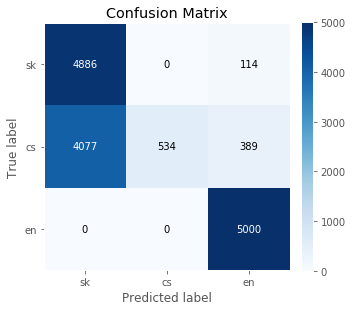

In [22]:
plot_confusion_matrix(y_val, predictions1, ['sk', 'cs', 'en'])

In [23]:
f1_score(y_val, predictions1, average = 'weighted')

0.6149824401040264

# 4. Better Naive Bayes Model addressing class imbalance

In [88]:
naive_classifier2 = MultinomialNB(alpha = 0.04, fit_prior = False) 
# fit prior as False gives each class equal probability, * p(sk) not in the calculation

In [89]:
naive_classifier2.fit(X_train, y_train)

MultinomialNB(alpha=0.04, class_prior=None, fit_prior=False)

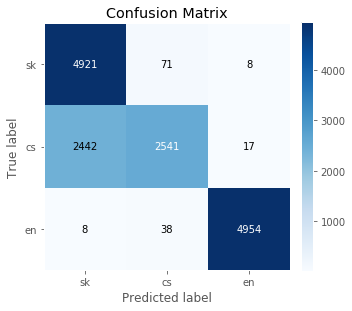

In [90]:
predictions2 = naive_classifier2.predict(X_val)
plot_confusion_matrix(y_val, predictions2, ['sk', 'cs', 'en'])

In [91]:
f1_score(y_val, predictions2, average = 'weighted')

0.8175896898193542

# 5. Better Naive Bayes Model using Subwords

In [28]:
# taken from https://arxiv.org/abs/1508.07909

import re, collections
def get_stats(vocab):
    """
    Subwords used in Natural Language Translation where we try and translate parts of words, when we have not seen new words
    """
    pairs = collections.defaultdict(int) 
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq 
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word] 
    return v_out

In [29]:
def get_vocab(data):
    """
    vocab dictionary of words and how often they occur in the dataset
    """

    words = []
    for sentence in data:
        words.extend(sentence.split())
        
    vocab = defaultdict(int)
    for word in words:
        vocab[' '.join(word)] += 1
        
    return vocab

In [30]:
vocab = get_vocab(sentences_train)

In [31]:
# also taken from original paper, iteratively improves vocab, #iterations can also be considered a hyperparameter
for i in range(1000):
    pairs = get_stats(vocab)
    best = max(pairs, key=pairs.get) 
    vocab = merge_vocab(best, vocab)

In [32]:
#merges are subwords we want to create from our dataset, creates a dict of subwords and how often they occur in the dataset
merges = defaultdict(int)
for k, v in vocab.items():
    for subword in k.split():
        if len(subword) >= 2:
            merges[subword] += v

In [33]:
merge_ordered = sorted(merges, key=merges.get, reverse=True)

In [34]:
pkl.dump(merge_ordered, open('merge_ordered.pkl', 'wb'))

In [35]:
def split_into_subwords(text):
    """
    Takes a sentence applies and returns subwords
    """
    merges = pkl.load(open('merge_ordered.pkl', 'rb'))
    subwords = []
    for word in text.split():
        for subword in merges:
            subword_count = word.count(subword)
            if subword_count > 0:
                word = word.replace(subword, ' ')
                subwords.extend([subword]*subword_count)
    return ' '.join(subwords)

In [36]:
data_preprocessed_subwords = {k: [split_into_subwords(sentence) for sentence in v] for k, v in data_preprocessed.items()}

In [37]:
show_statistics(data_preprocessed_subwords)

Language : sk
Number of sentences : 100
Number of words : 4430
Number of unique words : 211
Sample Extract : pán de and es al as cu ne as vy li ve ak je an ri od not in de ie er or mu re vy ím ad že in de ia to me al po ív už ed pr ým la bo it le ia ej dô al aj ým že al tr na na me zo st ie ov pr up

Language : cs
Number of sentences : 10
Number of words : 339
Number of unique words : 117
Sample Extract : po je me or že je ím le cí je it et en zi za in is at ní ad tr je vý da

Language : en
Number of sentences : 100
Number of words : 4477
Number of unique words : 167
Sample Extract : an and st de un ou ch ro ap it le it



We can see that we have evened out the number of unique words for all languages

In [38]:
data_train_subwords = []
for sentence in sentences_train:
    data_train_subwords.append(split_into_subwords(sentence))

In [39]:
data_val_subwords = []
for sentence in sentences_val:
    data_val_subwords.append(split_into_subwords(sentence))

In [40]:
vectorizer2 = CountVectorizer()

In [41]:
X_train = vectorizer2.fit_transform(data_train_subwords)
X_val = vectorizer2.transform(data_val_subwords)

In [78]:
naive_classifier3 = MultinomialNB(alpha = 0.35, fit_prior = False) 
naive_classifier3.fit(X_train, y_train)

MultinomialNB(alpha=0.35, class_prior=None, fit_prior=False)

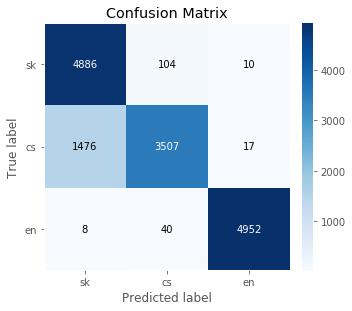

In [79]:
predictions3 = naive_classifier3.predict(X_val)
plot_confusion_matrix(y_val, predictions3, ['sk', 'cs', 'en'])

In [80]:
f1_score(y_val, predictions3, average = 'weighted')

0.887570747741248

In [94]:
joblib.dump(naive_classifier3, 'final-model.joblib')
joblib.dump(vectorizer, 'final-model.joblib')

['final-model.joblib']